In [1]:
import torch
import io
import os
import json
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
import asyncio
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def x_to_filename(x):
    return f'{x[0]}_{x[1]}_{x[2]}_{x[3]}.json'

def filename_to_x(filename):
    return [float(x) for x in filename[:-5].split('_')]

NUM_CORES=14
running_tasks={}
async def wait_for_core_to_be_available():
    while len(running_tasks)>NUM_CORES:
        await asyncio.sleep(1.0)

async def evaluate_profile(x):
    await wait_for_core_to_be_available()
    filename=x_to_filename(x)
    running_tasks[filename]=True
    #display(filename)
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    #display(distances)
    if len(distances)==0 or min(distances)>0.001:
        config=json.dumps({
            'p':x[0],
            'm':x[1],
            't':x[2],
            'a':x[3]
        })
        p=await asyncio.create_subprocess_shell(f'cd case; ./evaluate_airfoil.sh \'{config}\'',stdout=asyncio.subprocess.PIPE)
        await p.wait()
        #os.system(f'cd case; ./evaluate_airfoil.sh \'{config}\'')
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    min_distance_index=distances.index(min(distances))
    with open("case/results/"+existing_result_files[min_distance_index]) as file:
        result=json.load(file)
        #display(result)
        running_tasks.pop(filename)
        return [result['C_L'],1/result['C_D']]


#await evaluate_profile([0.42,0.05,0.18,15])

In [2]:
x_lims=[(0.1,0.9),(-0.2,0.2),(0.05,0.3),(0.01,35)]

random_initial_X=False
INITIAL_X_COUNT=40
initial_X = None
if random_initial_X or len(os.listdir("case/results_random"))<INITIAL_X_COUNT:
    initial_X = torch.rand(INITIAL_X_COUNT,4, dtype=dtype, device=device)
    for d in range(4):
        initial_X[:,d]=x_lims[d][0]+initial_X[:,d]*(x_lims[d][1]-x_lims[d][0])
else:
    # get initial X from filenames in case/results folder
    initial_X=torch.tensor([filename_to_x(filename) for filename in os.listdir("case/results_random")],dtype=dtype,device=device)
    # take six random points from the initial X
    initial_X = initial_X[torch.randperm(initial_X.shape[0])[:INITIAL_X_COUNT]]

#display(initial_X)
y=await asyncio.gather(*[evaluate_profile(x.tolist()) for x in initial_X])
train_X=initial_X
train_Y = torch.tensor(y,dtype=dtype,device=device)

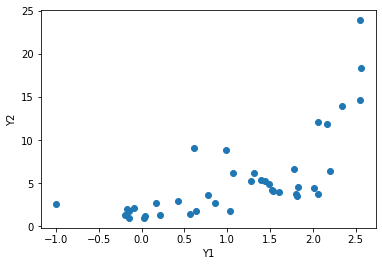

In [3]:
import plotting
plotting.plot_population(train_Y)

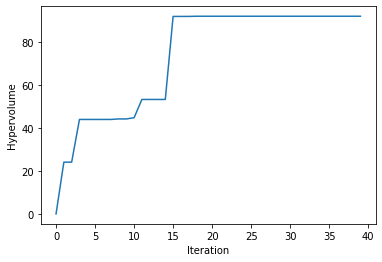

In [4]:
plotting.plot_hypervolume_over_iteration(train_Y)

In [5]:
bounds = torch.stack([torch.tensor(x_lims)[:,0], torch.tensor(x_lims)[:,1]])
bounds

tensor([[ 1.0000e-01, -2.0000e-01,  5.0000e-02,  1.0000e-02],
        [ 9.0000e-01,  2.0000e-01,  3.0000e-01,  3.5000e+01]])

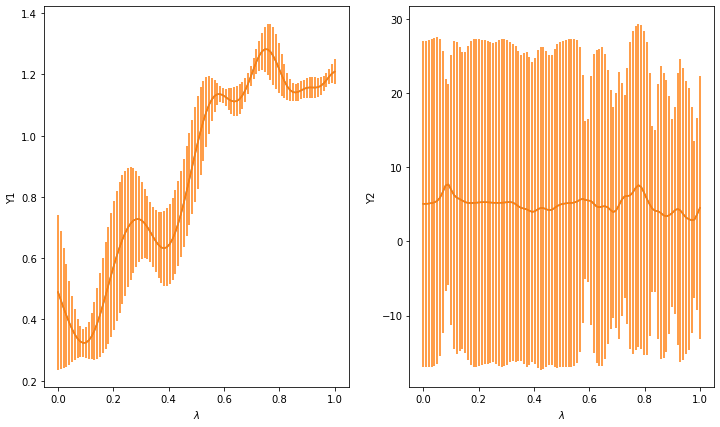

In [6]:
import plotting
def get_fitted_model(train_X,train_Y):
    train_Yvar = torch.full_like(train_Y, 0.01)
    gp= FixedNoiseGP(train_X, train_Y, train_Yvar)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    return gp

model=get_fitted_model(train_X,train_Y)
plotting.plot_model(model,[0.5,0.0,0.15,0],[0.5,0.0,0.15,30.0])

In [7]:

from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
#print(train_X)
#print(train_Y)
N_BATCH=10
ref_point=torch.tensor([-1.0, -2.0])
for iteration in range(1, N_BATCH + 1):
    gp=get_fitted_model(train_X,train_Y)
    #gp = SingleTaskGP(train_X, train_Y)
    #test_X=torch.rand(1,4)
    #print(test_X,": ",gp.posterior(train_X).mean,"+-",gp.posterior(train_X).variance.sqrt())

    #

    #acquisition_function = UpperConfidenceBound(gp, beta=0.1)
    partitioning=FastNondominatedPartitioning(ref_point=ref_point,Y=train_Y)
    acquisition_function = ExpectedHypervolumeImprovement(
        gp, ref_point=ref_point,
        partitioning=partitioning)

    candidate, acq_value = optimize_acqf(
        acquisition_function, bounds=bounds, q=1, num_restarts=1, batch_initial_conditions=train_X
    )
    print(candidate,": ",acq_value)
    predicted_Y=gp.posterior(candidate.unsqueeze(0)).mean
    prediceted_Y_var=gp.posterior(candidate.unsqueeze(0)).variance
    print(predicted_Y,"+-",prediceted_Y_var.sqrt())
    actual_value=await evaluate_profile(candidate.tolist())
    print(actual_value)
    # add new data to training data
    train_X = torch.cat([train_X, candidate.unsqueeze(0)])
    train_Y = torch.cat([train_Y, torch.tensor(actual_value,dtype=dtype,device=device).unsqueeze(0)])
    #print(train_Y)


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7206,  0.2000,  0.2990, 27.0137], dtype=torch.float64) :  tensor(2.2281, dtype=torch.float64)
tensor([[ 2.6432, 12.3366]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.2677, 3.1178]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.67573, 78.48431098623385]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.6592,  0.2000,  0.3000, 27.0195], dtype=torch.float64) :  tensor(4.3089, dtype=torch.float64)
tensor([[ 2.6777, 75.9150]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.1120, 2.5389]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.64736, 39.95509047830239]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7209,  0.2000,  0.2485, 27.0190], dtype=torch.float64) :  tensor(2.7430, dtype=torch.float64)
tensor([[ 2.6645, 76.6278]], dtype=torch.float64, grad_fn=<TransposeBackward0>) +- tensor([[0.0762, 2.0764]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.70983, 565.8444946159897]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.5789,  0.2000,  0.1488, 27.0190], dtype=torch.float64) :  tensor(18.5246, dtype=torch.float64)
tensor([[  2.6260, 464.8817]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[ 0.1859, 17.8719]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.70669, 31.161579019532073]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7210,  0.2000,  0.1290, 27.0190], dtype=torch.float64) :  tensor(13.4211, dtype=torch.float64)
tensor([[  2.6730, 512.5825]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[ 0.1051, 13.2313]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.63747, 17.731125217206284]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7209,  0.2000,  0.2358, 27.0267], dtype=torch.float64) :  tensor(7.0535, dtype=torch.float64)
tensor([[  2.6842, 564.4520]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[0.0511, 2.2357]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.64935, -234.4907798225374]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.5185,  0.2000,  0.2486, 27.0190], dtype=torch.float64) :  tensor(13.5041, dtype=torch.float64)
tensor([[  2.6777, 440.0987]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[ 0.1123, 20.5458]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.57554, 24.574673832641555]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7247,  0.2000,  0.2486, 27.0251], dtype=torch.float64) :  tensor(4.8082, dtype=torch.float64)
tensor([[  2.6737, 564.3564]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[0.0468, 2.4300]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.70283, 65.42747037771278]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.9000,  0.2000,  0.2485, 27.0225], dtype=torch.float64) :  tensor(7.1694, dtype=torch.float64)
tensor([[  2.6095, 461.2069]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[ 0.1268, 18.9453]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.7318, 67.55935088975664]


/home/olep/.local/lib/python3.10/site-packages/botorch/acquisition/multi_objective/analytic.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ref_point = torch.tensor(


tensor([ 0.7208,  0.2000,  0.2486, 27.0339], dtype=torch.float64) :  tensor(5.4766, dtype=torch.float64)
tensor([[  2.6917, 564.3837]], dtype=torch.float64,
       grad_fn=<TransposeBackward0>) +- tensor([[0.0377, 2.4047]], dtype=torch.float64, grad_fn=<SqrtBackward0>)


[2.72245, 124.47161798166782]


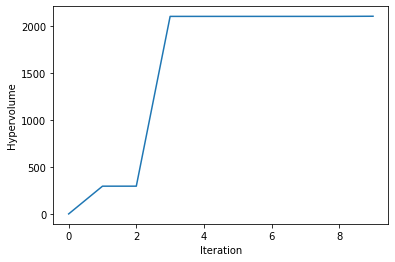

In [8]:
plotting.plot_hypervolume_over_iteration(train_Y[INITIAL_X_COUNT:,:])

In [9]:
from botorch.utils.multi_objective.box_decompositions.dominated import (
    DominatedPartitioning,
)
import pandas as pd
def hypervolume(Y,ref_point=torch.tensor([-1,-2])):
    # compute hypervolume of Y
    bd = DominatedPartitioning(ref_point=ref_point, Y=Y)
    hv=bd.compute_hypervolume().item()
    return hv
data=pd.DataFrame({
    "iteration":range(1,N_BATCH+1),
    "hypervolume":[hypervolume(train_Y[0:INITIAL_X_COUNT+i,:]) for i in range(1,N_BATCH+1)]
})
display(data)
print(data.to_latex(index=False))

,iteration,hypervolume
0,1,295.838596
1,2,295.838596
2,3,2106.606541
3,4,2106.606541
4,5,2106.606541
5,6,2106.606541
6,7,2106.606541
7,8,2106.606541
8,9,2108.134760
9,10,2108.852993


\begin{tabular}{rr}
\toprule
 iteration &  hypervolume \\
\midrule
         1 &   295.838596 \\
         2 &   295.838596 \\
         3 &  2106.606541 \\
         4 &  2106.606541 \\
         5 &  2106.606541 \\
         6 &  2106.606541 \\
         7 &  2106.606541 \\
         8 &  2106.606541 \\
         9 &  2108.134760 \\
        10 &  2108.852993 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_82493/3233043266.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data.to_latex(index=False))


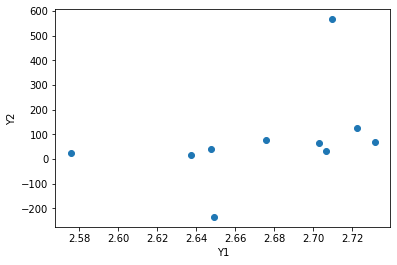

In [10]:
plotting.plot_population(train_Y[INITIAL_X_COUNT:,:])

In [11]:
print(train_X)
print(train_Y)

tensor([[ 6.1000e-01,  5.4285e-02,  1.3451e-01,  2.1777e+01],
        [ 2.2206e-01,  1.0263e-01,  1.9729e-01,  7.5232e+00],
        [ 4.2076e-01,  1.1872e-01,  1.0441e-01,  1.7589e+01],
        [ 7.1927e-01, -1.4612e-01,  1.9343e-01,  3.4736e+01],
        [ 4.5826e-01, -1.4955e-01,  1.5524e-01,  2.6218e+01],
        [ 7.4762e-01, -5.4062e-02,  1.6042e-01,  2.6191e+01],
        [ 6.3015e-01,  3.7878e-02,  1.7296e-01,  2.6037e+00],
        [ 4.1060e-01,  1.7214e-01,  2.6322e-01,  1.7198e+01],
        [ 1.6034e-01,  4.2301e-02,  1.7333e-01,  9.6864e+00],
        [ 5.4772e-01,  9.6025e-02,  1.6167e-01,  1.7874e+01],
        [ 6.2766e-01,  1.3606e-01,  1.6957e-01,  1.7585e+01],
        [ 3.0640e-01,  7.8970e-02,  1.4058e-01,  3.0351e+01],
        [ 1.0387e-01, -4.8587e-02,  2.2228e-01,  1.3167e+01],
        [ 6.5155e-01, -3.1770e-02,  2.6572e-01,  2.0702e+01],
        [ 5.1948e-01,  1.8119e-01,  1.9960e-01,  2.3379e+01],
        [ 1.6249e-01,  1.3232e-01,  2.7471e-01,  1.6463e-01],
        